In [1]:
import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import norm as Normal_Dist
import matplotlib.pyplot as plt

# Formulating the portfolio optimization problem as a SOCP.

In [2]:
ones = np.ones(4)
r_hat = np.array([0.12, 0.10, 0.07, 0.03])
Sigma = np.array([
    [0.0064, 0.0008, -0.0011, 0.0],
    [0.0008, 0.0025, 0.0, 0.0],
    [-0.0011, 0.0, 0.0004, 0.0],
    [0.0, 0.0, 0.0, 0.0]
])
Sigma_root = sqrtm(Sigma)

In [3]:
# Here, we form the constraints and solve the problem within the function (so it is useful to use in a for-loop
# later on)
def optimization(epsilon, r_hat, Sigma_root):
    x = cp.Variable(4)
    ones = np.ones(4)
    norm_inv_cdf_eps = Normal_Dist.ppf(epsilon)
    q = -.01

    constraints = [
        ones*x == 1,
        x <= .4,
        x[3]<=.2,
        x >= .05,
        cp.norm(cp.matmul(Sigma_root,x))*(norm_inv_cdf_eps) >= (q-r_hat*x)
    ]
    obj = cp.Maximize(r_hat*x)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return prob.value, x.value

In [4]:
opt_val, opt_soln = optimization(1e-4, r_hat, Sigma_root)
print("Optimal value:", opt_val)
print("Optimal soln:", opt_soln)

Optimal value: 0.09183017078042251
Optimal soln: [0.29864447 0.29659824 0.35475729 0.05      ]


# Now lets solve the problem for a variety of values of ε from $10^{-6}$ to $10^{-1}$ and observe the optimal values of $\hat{r}^{T}x$ versus ε.

In [5]:
# epsilons generated between 1e-6 and 1e-1 in log scale
epsilons = np.logspace(-6,-1)

In [6]:
rhat_vals = [] # optimal return values (i.e. the prob.value outputs)
opt_x_vals = [] # optimal portfolio allocations
#going over the values of epsilon
for eps in epsilons:
    rhat, optx = optimization(eps,r_hat, Sigma_root)
    rhat_vals.append(rhat)
    opt_x_vals.append(optx)

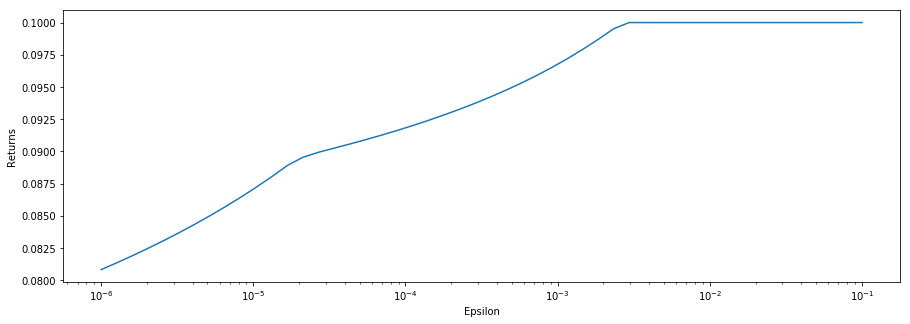

In [7]:
# Plotting returns
plt.figure(figsize=(15,5))
plt.plot(epsilons, rhat_vals)
plt.xlabel('Epsilon')
plt.ylabel('Returns')
plt.xscale('log')

We observe that as the risk tolerance $\epsilon$ decreases our optimal mean returns, $\hat{r}^Tx^*$ decreases as well. Thus less risk implies less reward meaning there is a risk-reward tradeoff. 

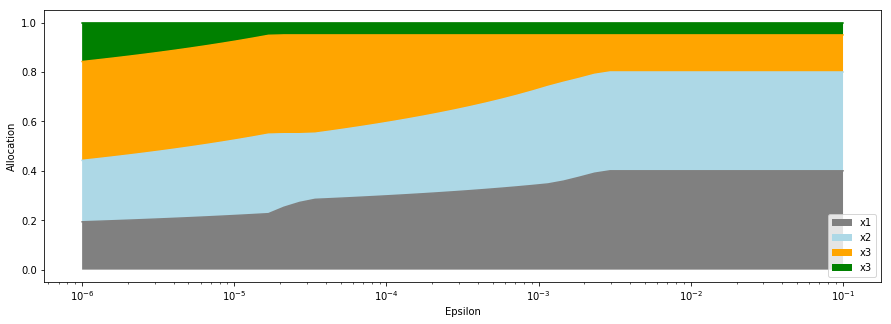

In [8]:
# Plotting allocations (Note: the sum of all the portfolio allocations is 1, so we do not plot that!)
plt.figure(figsize=(15, 5))
y1 = np.array([item[0] for item in opt_x_vals])
plt.plot(epsilons, y1, c = 'gray')
plt.fill_between(epsilons, 0, y1, facecolor = 'gray', label = 'x1')

y2 = np.array([item[1] for item in opt_x_vals])
plt.plot(epsilons, y1+y2, c= 'lightblue')
plt.fill_between(epsilons, y1, y1+y2, facecolor = 'lightblue', label = 'x2')

y3 = np.array([item[2] for item in opt_x_vals])
plt.plot(epsilons, y1+y2+y3, c= 'orange')
plt.fill_between(epsilons, y1+y2, y1+y2+y3, facecolor = 'orange', label = 'x3')



y4= np.array([item[3] for item in opt_x_vals])
plt.plot(epsilons, y1+y2+y3+y4, c= 'green')
plt.fill_between(epsilons, y1+y2+y3, y1+y2+y3+y4, facecolor = 'green', label = 'x3')

plt.legend(loc = 'best')
plt.xlabel('Epsilon')
plt.ylabel('Allocation')
plt.xscale('log')

We observe that as our risk tolerance $\epsilon$ goes down we allocate more weight on the risk-free asset ($x_4$ shown in green).
For higher values of epsilon most of our weight is on assets with higher returns $x_1 (gray), x_2(blue)$.

# Lets perform a Monte Carlo simulation and see how often we incur a loss.

In [9]:
# Just regenerating the optimal x again with 10e-4 as our epsilon
optimal_x_part_1 = optimization(1e-4, r_hat, Sigma_root)[1]
optimal_x_part_1 = np.array(optimal_x_part_1)

In [10]:
# Generating 10000 random samples. Note: could have used np.random.randn as well
returns = []
np.random.seed(777)
for i in range(10000):
    rand_r = np.random.multivariate_normal(r_hat, Sigma)
    returns.append(np.dot(rand_r, optimal_x_part_1))
returns = np.array(returns)

Text(0, 0.5, 'Frequency')

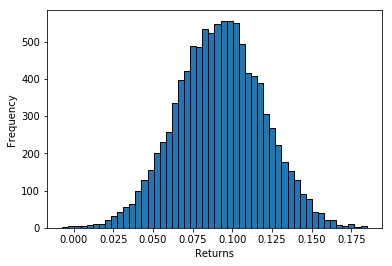

In [11]:
# Plot the histogram of random returns 
plt.hist(returns, 50, ec='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')

In [12]:
print("Mean of the returns:", returns.mean())

Mean of the returns: 0.09194666595656943


In [13]:
print("Percentage of loss:", (returns < 0).sum() / returns.size)

Percentage of loss: 0.0007
